In [6]:
import  chess
import chess.engine
import numpy as np
import tdchess.train
import tensorflow as tf
import pdb
import random

In [7]:
SKIP_FIRST_MOVES = 6
MAX_POSITIONS_PER_GAME = 5
MAX_GAMES = 2e6

def parse_result(result_header):
    if '1-0' in result_header:
        return 1
    if '0-1' in result_header:
        return -1
    if '1/2-1/2' in result_header:
        return 0

def augment_board(board):  
    ''' randomise two moves '''
    for _ in range(2):
        random_move = random.choice(list(board.legal_moves))
        board.push(random_move)
    return board
    
def parse_game(game):
    board = chess.Board()
    fens = []
    for uci in game.mainline_moves():
        pieces_before = len(board.piece_map().keys())
        board.push(uci)
        # Determine if something was taken
        pieces_after = len(board.piece_map().keys())
        if board.fullmove_number > SKIP_FIRST_MOVES and pieces_before == pieces_after:
            if random.randint(0,10) >= 7 and len(fens) < MAX_POSITIONS_PER_GAME:
                try:
                    board_copy = augment_board(board.copy())
                    fens.append(board_copy.fen())
                except:
                    pass
    return fens

#with open('data/ccrl/CCRL-4040.[1189229].pgn', 'r') as f:
with open('/Users/silfverstrom/Documents/data/chess/lichess_db_standard_rated_2017-02.pgn', 'r') as f:

    fens = []
    results = []
    i = 0 
    while True and i < MAX_GAMES:
        game = chess.pgn.read_game(f)
        
        if game is None:
            break
        
        result_header = game.headers["Result"]
        result = parse_result(result_header)
        
        # Skip drawn game(low signal)
        if result == 0:
            continue

        f_ = parse_game(game)
        for fen in f_:
            fens.append(fen)
            results.append(result)

        if i % 500 == 0:
            print("Loop ", i, "Positions = ", len(fens))
        i = i + 1

print(len(fens))

Loop  0 Positions =  5


KeyboardInterrupt: 

In [2]:
np.save('data/ccrl/fens_lichess_v1.npy',np.array(fens))


NameError: name 'fens' is not defined

In [3]:
def show_board(fen):
    print(fen)
    board = chess.Board(fen)
    return board
show_board(fens[1000])

NameError: name 'fens' is not defined

In [326]:
len(fens)

1602996

In [108]:
len(results)

1465915

In [325]:
np.save('data/ccrl/fens_15e5_v2.npy',np.array(fens))
np.save('data/ccrl/results_15e5_v2.npy',np.array(results))
fens2 = np.load('data/ccrl/fens_15e5_v2.npy')
lichess_fens = fens
fens.extend(fens2)


In [8]:
def normalise(Y):
    mi = min(Y)
    mx = max(Y)
    Y_norm = []
    for y in Y:
        d = mx - mi
        if d == 0:
            d = 1
        y_ = (y - mi) / d
        Y_norm.append(y_)
    return Y_norm

path = "/usr/local/Cellar/stockfish/12/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(path)
chess.engine.Limit(depth=0)

def get_training_data(board):

    x = []
    # add meta
    tt = [1,0] if board.turn else [0,1]
    piece_map = board.piece_map()
    empty = [0 for _ in range(12)]
    pieces = ['p','n','b','r','q','k','P','N','B','R','Q','K']

    rep = [empty.copy() for _ in range(8*8)]

    castle_rights = [0,0,0,0]
    if board.has_kingside_castling_rights(chess.WHITE):
        castle_rights[0] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        castle_rights[1] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        castle_rights[2] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        castle_rights[3] = 1

    for key in piece_map:
        val = str(piece_map[key])
        ind = pieces.index(val)

        label = None
        if ind <= 5 and not board.turn: #black piece, black to move
            label = 1
        if ind <= 5 and board.turn: #black piece, white to move
            label = -1

        if ind > 5 and board.turn: #white piece, white to move
            label = 1
        if ind > 5 and not board.turn: #black piece, black to move
            label = -1

        rep[key][ind] = label
    rep = np.array(rep).flatten()
    x.extend(rep)
    x.extend(tt)
    x.extend(castle_rights)
    
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
    pieces = [wp, bp, wn, bn, wb, bb, wr, br, wq, bq]

    pieces = normalise(pieces)
    diff = [wp - bp, wn - bn, wb - bb, wr - br, wq - bq]
    diff = normalise(diff)
    x.extend(pieces)
    x.extend(diff)
    
    return x

X = []
Y = []
print('Starting', len(fens))
for fen in fens:

    board = chess.Board(fen)
    ev = engine.analyse(board, chess.engine.Limit(depth=0))

    fen = board.fen()
    x = get_training_data(board)
    try:
        y = float(str(ev['score'].white()))
        
        X.append(x)
        Y.append(y)
        
        if len(X) % 1000 == 0:
            print("Step {}".format(len(X)))
    except:
        pass

Starting 726


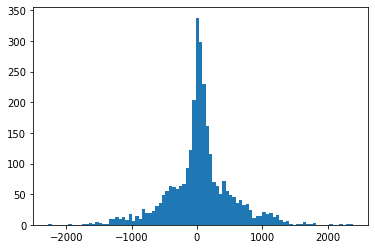

In [328]:
import matplotlib.pyplot as plt

len(X)
np.mean(Y)
len(Y)
min(Y)

def normalise(Y):
    mi = min(Y)
    mx = max(Y)
    Y_norm = []
    for y in Y:
        y_ = (y - mi) / (mx - mi)
        Y_norm.append(y_)
    return Y_norm


plt.hist(Y[0:3000], bins='auto')
plt.show()

In [307]:
def denormalise(normalized_d, max_d, min_d):
    return normalized_d * (max_d - min_d) + min_d

print(max(Y_norm))
print(min(Y_norm))



NameError: name 'Y_norm' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

Y = normalise(Y)

X_train, X_test, y_train, y_test = train_test_split(X,Y)

np.save("data/ccrl/mixed_v1_xtrain.npy", np.array(X_train))
np.save("data/ccrl/mixed_v1_ytrain.npy", np.array(y_train))

np.save("data/ccrl/mixed_v1_xtest.npy", np.array(X_test))
np.save("data/ccrl/mixed_v1_ytest.npy", np.array(y_test))



In [309]:
Y
#y_train_ = normalise(y_train)
#y_test_ = normalise(y_test)

#np.save("data/ccrl/15e5_v2_ytrain_norm.npy", np.array(y_train_))
#np.save("data/ccrl/15e5_v2_ytest_norm.npy", np.array(y_test_))

[0.476,
 0.4807272727272727,
 0.4469090909090909,
 0.5325454545454545,
 0.502,
 0.49363636363636365,
 0.5983636363636363,
 0.49981818181818183,
 0.46763636363636363,
 0.41909090909090907,
 0.474,
 0.4763636363636364,
 0.49945454545454543,
 0.4669090909090909,
 0.3390909090909091,
 0.47345454545454546,
 0.48563636363636364,
 0.4889090909090909,
 0.40563636363636363,
 0.48418181818181816,
 0.47945454545454547,
 0.4894545454545455,
 0.48854545454545456,
 0.47163636363636363,
 0.38036363636363635,
 0.52,
 0.4843636363636364,
 0.4763636363636364,
 0.4310909090909091,
 0.4527272727272727,
 0.4738181818181818,
 0.49363636363636365,
 0.5585454545454546,
 0.46545454545454545,
 0.4723636363636364,
 0.4863636363636364,
 0.49054545454545456,
 0.5032727272727273,
 0.25727272727272726,
 0.4,
 0.4743636363636364,
 0.47363636363636363,
 0.22654545454545455,
 0.5005454545454545,
 0.44145454545454543,
 0.24763636363636363,
 0.524,
 0.4769090909090909,
 0.6501818181818182,
 0.49054545454545456,
 0.473818

In [94]:
len(X)
print(y_train[1], y_train_[1])
print(denormalise(y_train_[1], max(y_train), min(y_train)))

v = 0.0810
print(denormalise(v, max(y_train), min(y_train)))

v1 = 129.9252
v2 = 0.0958

print(v1 / max(y_test))
print(v2 / max(y_test_))

print()
#MAE SGD
#1464/1464 [==============================] - 237s 162ms/step - loss: 0.1943 - mae: 0.1944 - val_loss: 0.1045 - val_mae: 0.1045
#Epoch 2/100
#1464/1464 [==============================] - 127s 87ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.1063 - val_mae: 0.1063
#Epoch 3/100
#1464/1464 [==============================] - 137s 94ms/step - loss: 0.0810 - mae: 0.0810 - val_loss: 0.0985 - val_mae: 0.0985
#Epoch 4/100
#1464/1464 [==============================] - 137s 94ms/step - loss: 0.0789 - mae: 0.0789 - val_loss: 0.0958 - val_mae: 0.0958
#Epoch 5/100
#1464/1464 [==============================] - 136s 93ms/step - loss: 0.0777 - mae: 0.0777 - val_loss: 0.0951 - val_mae: 0.0951
#1464/1464 [==============================] - 124s 85ms/step - loss: 0.0765 - mae: 0.0765 - val_loss: 0.0911 - val_mae: 0.0911

80.0 0.48054545454545455
80.0
-2117.5
0.06137231931979215
0.0958


In [121]:
#model = tf.keras.models.load_model("/Users/silfverstrom/Workspace/link/projects/td-chess/output/15e5_v2_adam/15e5_v2_adam")
model = tf.keras.models.load_model("/Users/silfverstrom/Workspace/link/projects/td-chess/output/v4/v4")

X_test = np.load("data/ccrl/15e5_v2_xtest.npy")
y_test = np.load("data/ccrl/15e5_v2_ytest.npy")
y_test_ = np.load("data/ccrl/15e5_v2_ytest_norm.npy")

fens = np.load('data/ccrl/fens_15e5_v2.npy')


In [122]:
model.predict(np.array(X_test[50:60]))

array([[0.46424   ],
       [0.4812951 ],
       [0.4739234 ],
       [0.48594776],
       [0.5820397 ],
       [0.49870428],
       [0.43485194],
       [0.57582927],
       [0.4857293 ],
       [0.46903396]], dtype=float32)

In [123]:
y_test_[50:60]

array([0.49883396, 0.53101679, 0.53614739, 0.51352612, 0.51655784,
       0.59025187, 0.43050373, 0.60984142, 0.58232276, 0.40718284])

In [124]:
model.predict(np.array([get_training_data(board)]))

NameError: name 'board' is not defined

In [20]:
path = "/usr/local/Cellar/stockfish/12/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(path)
chess.engine.Limit(depth=0)

def find_best_move(board):
    if board.turn:
        best_score =(-99999, None)

    else:
        best_score =(99999, None)
        
    all_moves = []
    for move in board.legal_moves:
        board.push(move)
        score = model.predict(np.array([get_training_data(board)]))
        board.pop()
        
        if score < best_score[0] and not board.turn:
            best_score = (score, move)
        if score > best_score[0] and board.turn:
            best_score = (score, move)
        all_moves.append((score, move))

    print(best_score)
    return best_score, all_moves

def get_back(fen):
    i = 401
    #fen = 'N1b2k1r/pp1p1ppp/2p5/8/5N2/5P2/PPP3PP/R3KB1R b KQ - 0 15'
    #board = chess.Board(fens[i])
    board = chess.Board(fen)

    this_score = model.predict(np.array([get_training_data(board)]))
    score, move = find_best_move(board)
    ev = engine.analyse(board, chess.engine.Limit(depth=0))
    engine_score = float(str(ev['score'].white()))

    print(score, move, engine_score)
    print("centipawns", denormalise(score, max(y_test), min(y_test)))
    return board

In [10]:
get_back('r5k1/ppN2pb1/1n4p1/6np/3Pr3/1P2P2q/PBQ1BP2/2R2RK1 w - - 0 22')

(array([[0.5194162]], dtype=float32), Move.from_uci('c2e4'))
(array([[0.5194162]], dtype=float32), Move.from_uci('c2e4')) [(array([[0.47188866]], dtype=float32), Move.from_uci('c7e8')), (array([[0.5181808]], dtype=float32), Move.from_uci('c7a8')), (array([[0.4769079]], dtype=float32), Move.from_uci('c7e6')), (array([[0.46917066]], dtype=float32), Move.from_uci('c7a6')), (array([[0.48033535]], dtype=float32), Move.from_uci('c7d5')), (array([[0.47983453]], dtype=float32), Move.from_uci('c7b5')), (array([[0.46243134]], dtype=float32), Move.from_uci('e2a6')), (array([[0.48593014]], dtype=float32), Move.from_uci('e2h5')), (array([[0.47501302]], dtype=float32), Move.from_uci('e2b5')), (array([[0.4712347]], dtype=float32), Move.from_uci('e2g4')), (array([[0.46533033]], dtype=float32), Move.from_uci('e2c4')), (array([[0.4795797]], dtype=float32), Move.from_uci('e2f3')), (array([[0.4844665]], dtype=float32), Move.from_uci('e2d3')), (array([[0.481751]], dtype=float32), Move.from_uci('e2d1')), (a

NameError: name 'denormalise' is not defined

In [130]:
get_back('N1b2k1r/pp1p1ppp/2p5/8/5N2/5P2/PPP3PP/R3KB1R b KQ - 0 15')

(array([[0.55753165]], dtype=float32), Move.from_uci('d7d6'))
(array([[0.55753165]], dtype=float32), Move.from_uci('d7d6')) [(array([[0.56926984]], dtype=float32), Move.from_uci('h8g8')), (array([[0.5699485]], dtype=float32), Move.from_uci('f8g8')), (array([[0.5583966]], dtype=float32), Move.from_uci('f8e8')), (array([[0.5695863]], dtype=float32), Move.from_uci('f8e7')), (array([[0.5737413]], dtype=float32), Move.from_uci('h7h6')), (array([[0.5764695]], dtype=float32), Move.from_uci('g7g6')), (array([[0.568229]], dtype=float32), Move.from_uci('f7f6')), (array([[0.55753165]], dtype=float32), Move.from_uci('d7d6')), (array([[0.56977075]], dtype=float32), Move.from_uci('b7b6')), (array([[0.5849991]], dtype=float32), Move.from_uci('a7a6')), (array([[0.58602273]], dtype=float32), Move.from_uci('c6c5')), (array([[0.57971644]], dtype=float32), Move.from_uci('h7h5')), (array([[0.5816731]], dtype=float32), Move.from_uci('g7g5')), (array([[0.62334657]], dtype=float32), Move.from_uci('f7f5')), (a

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [131]:
get_back('r1bqr1k1/pp1n1pb1/2p2np1/3p3p/2PPp3/1PN1P2P/PB1NBPP1/2RQ1RK1 w - - 0 13')

(array([[0.47768742]], dtype=float32), Move.from_uci('c3e4'))
(array([[0.47768742]], dtype=float32), Move.from_uci('c3e4')) [(array([[0.42349118]], dtype=float32), Move.from_uci('c3d5')), (array([[0.42705947]], dtype=float32), Move.from_uci('c3b5')), (array([[0.47768742]], dtype=float32), Move.from_uci('c3e4')), (array([[0.47507644]], dtype=float32), Move.from_uci('c3a4')), (array([[0.46457613]], dtype=float32), Move.from_uci('c3b1')), (array([[0.41368285]], dtype=float32), Move.from_uci('e2h5')), (array([[0.41349065]], dtype=float32), Move.from_uci('e2g4')), (array([[0.46779117]], dtype=float32), Move.from_uci('e2f3')), (array([[0.46964368]], dtype=float32), Move.from_uci('e2d3')), (array([[0.45412353]], dtype=float32), Move.from_uci('d2e4')), (array([[0.46923193]], dtype=float32), Move.from_uci('d2f3')), (array([[0.4674405]], dtype=float32), Move.from_uci('d2b1')), (array([[0.4663447]], dtype=float32), Move.from_uci('b2a3')), (array([[0.4678294]], dtype=float32), Move.from_uci('b2a1'

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [13]:
def find_best_move_engine(board):
    if board.turn:
        best_score =(-99999, None)

    else:
        best_score =(99999, None)
    all_moves = []

    for move in board.legal_moves:
        board.push(move)
        ev = engine.analyse(board, chess.engine.Limit(depth=0))
        score = float(str(ev['score'].white()))
        board.pop()
        
        if score < best_score[0] and not board.turn:
            best_score = (score, move)
        if score > best_score[0] and board.turn:
            best_score = (score, move)
        all_moves.append((score, move))
    print(best_score)
    return best_score, all_moves

def get_top_1(pos):
    positive = 0
    negative = 0
    for fen in pos:
        board = chess.Board(fen)
        ev = engine.analyse(board, chess.engine.Limit(depth=0))

        fen = board.fen()
        x = get_training_data(board)
        try:
            engine_score, engine_moves  = find_best_move_engine(board)
            network_score, network_moves = find_best_move(board)
        except:
            continue
        score = network_score[0]
        move = network_score[1]
        #print("Network score", network_score, denormalise(score, max(y_test), min(y_test)))
        #print("engine score", engine_score)
        
        turn = board.turn
        em = sorted(engine_moves, key=lambda tup: tup[0], reverse=turn)[0:1]
        
        found = False
        for v_ in em:
            if str(v_[1]).strip() == str(move).strip():
                found = True
        
        if found:
            positive = positive + 1
        else:
            negative = negative + 1
        print("score is", positive, negative)
        
    return positive, negative

In [14]:
pos, neg = get_top_1(fens[1:50])
print(pos, neg)

(203.0, Move.from_uci('f3g4'))
(array([[0.5057675]], dtype=float32), Move.from_uci('f3g4'))
score is 1 0
(218.0, Move.from_uci('b1a3'))
(array([[0.5011693]], dtype=float32), Move.from_uci('b2a3'))
score is 1 1
(-246.0, Move.from_uci('h7h6'))
(array([[0.47728136]], dtype=float32), Move.from_uci('d7g4'))
score is 1 2
(74.0, Move.from_uci('e3f2'))
(array([[0.5160145]], dtype=float32), Move.from_uci('g4f5'))
score is 1 3
(63.0, Move.from_uci('h4e7'))
(array([[0.499207]], dtype=float32), Move.from_uci('h4e7'))
score is 2 3
(20.0, Move.from_uci('d7e8'))
(array([[0.49507725]], dtype=float32), Move.from_uci('d5c3'))
score is 2 4
(1.0, Move.from_uci('c3d5'))
(array([[0.5152259]], dtype=float32), Move.from_uci('c3d5'))
score is 3 4
(0.0, Move.from_uci('e5e4'))
(array([[0.48929012]], dtype=float32), Move.from_uci('e5d4'))
score is 3 5
(403.0, Move.from_uci('f3e5'))
(array([[0.5198195]], dtype=float32), Move.from_uci('d4e5'))
score is 3 6
(-71.0, Move.from_uci('d2d4'))
(array([[0.5012416]], dtype=

In [9]:
# 33 14 top 5 accuracy
# 23 24 top 3 accuracy
# 13 34 top 1 accuracy

#lc_v1
#score is top 5 37 11
#score is top 1 22 26


In [26]:
model = tf.keras.models.load_model("/Users/silfverstrom/Workspace/link/projects/td-chess/output/lc_v1/lc_v1")

print("mu", model.predict(np.array([get_training_data(chess.Board('8/8/5p2/1PP2k2/5P1p/P1b4P/Q4K2/3q4 w - - 0 55'))])))

print("mu", model.predict(np.array([get_training_data(chess.Board('8/8/5p2/1PP2k2/5P1p/P1b4P/5K2/1R6 b - - 0 55'))])))


get_top_1(['8/8/5p2/bPP2k2/5P1p/P2q4/Q4K1P/5R2 w - - 2 53'])




mu [[0.53169197]]
mu [[0.52457535]]
(667.0, Move.from_uci('a2b1'))
(array([[0.50288]], dtype=float32), Move.from_uci('f1d1'))
score is 0 1


(0, 1)

In [17]:
get_top_1(['3r3k/1p3pp1/p7/3Np1q1/1PP1P1P1/5P1r/P5Q1/3R2K1 b - - 4 31'])
chess.Board('3r3k/1p3pp1/p7/3Np1q1/1PP1P1P1/5P1r/P5Q1/3R2K1 b - - 4 31')

b, all_moves = find_best_move_r(chess.Board('3r3k/1p3pp1/p7/3Np1q1/1PP1P1P1/5P1r/P5Q1/3R2K1 b - - 4 31'))



(-435.0, Move.from_uci('g5h4'))
(array([[0.47394553]], dtype=float32), Move.from_uci('h3h2'))
score is 0 1


(array([[0.49145848]], dtype=float32), Move.from_uci('h8g8'))
(array([[0.4904056]], dtype=float32), Move.from_uci('h8h7'))
(array([[0.48988447]], dtype=float32), Move.from_uci('d8g8'))
(array([[0.4924142]], dtype=float32), Move.from_uci('d8f8'))
(array([[0.48860916]], dtype=float32), Move.from_uci('d8e8'))
(array([[0.49287057]], dtype=float32), Move.from_uci('d8c8'))
(array([[0.49197587]], dtype=float32), Move.from_uci('d8b8'))
(array([[0.4960027]], dtype=float32), Move.from_uci('d8a8'))
(array([[0.48692986]], dtype=float32), Move.from_uci('d8d7'))
(array([[0.48450628]], dtype=float32), Move.from_uci('d8d6'))
(array([0.49645922], dtype=float32), Move.from_uci('d8d5'))
(array([0.5379933], dtype=float32), Move.from_uci('g5e7'))
(array([[0.49838528]], dtype=float32), Move.from_uci('g5h6'))
(array([[0.49943778]], dtype=float32), Move.from_uci('g5g6'))
(array([0.5418758], dtype=float32), Move.from_uci('g5f6'))
(array([0.5483416], dtype=float32), Move.from_uci('g5h5'))
(array([0.55126774], d

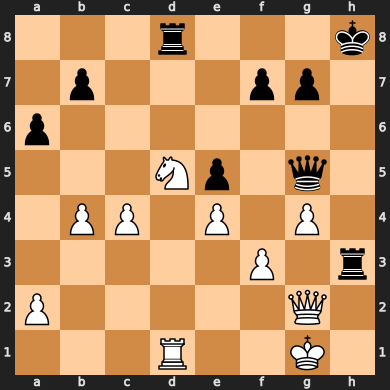

In [18]:
for i in all_moves:
    print(i)
chess.Board('3r3k/1p3pp1/p7/3Np1q1/1PP1P1P1/5P1r/P5Q1/3R2K1 b - - 4 31')

#get_top_1(['2rb1r1k/1p3pp1/p1np2qp/3Np3/4P3/1BP1R3/PP3PPP/R2Q2K1 b - - 4 18'])


In [19]:
print(b)
#get_top_1(['2r2r1k/1p3pp1/pNnp2qp/4p3/4P3/1BP1R3/PP3PPP/R2Q2K1 b - - 0 19'])


(array([[0.48151082]], dtype=float32), Move.from_uci('h3h4'))


In [157]:

get_top_1(['2rb1r1k/1p2npp1/p2p2qp/3Np3/4P3/1BP1R3/PP3PPP/R2Q2K1 w - - 5 19'])


(166.0, Move.from_uci('d5e7'))
(array([[0.4953642]], dtype=float32), Move.from_uci('d5c7'))
score is 0 1


(0, 1)

In [16]:
def find_best_move_r(board, depth=2):
    if depth == 0:
        out = model.predict(np.array([get_training_data(board)]))
        return out, []
    if board.turn:
        best_score =(-99999, None)

    else:
        best_score =(99999, None)
        
    all_moves = []
    for move in board.legal_moves:
        opp_turn = None
        if board.turn:
            opp_turn = False
        else:
            opp_turn = True
        if board.is_capture(move) or len(board.attackers(opp_turn, chess.parse_square(str(move)[2:4]))) > 0:
            board.push(move)
            out, _ = find_best_move_r(board, depth-1)

            score = out[0]
            board.pop()
        else:
            board.push(move)
            score = model.predict(np.array([get_training_data(board)]))
            board.pop()
        
        if score < best_score[0] and not board.turn:
            best_score = (score, move)
        if score > best_score[0] and board.turn:
            best_score = (score, move)
        all_moves.append((score, move))

    return best_score, all_moves

In [22]:
b, _ = find_best_move_r(chess.Board('5rk1/p1p2ppp/1p3n2/5R2/q1Pn4/3Pr1PP/2P1P3/2R1Q1K1 w - - 1 20'), 2)
print("hej", b)

hej (array([0.51925224], dtype=float32), Move.from_uci('f5b5'))


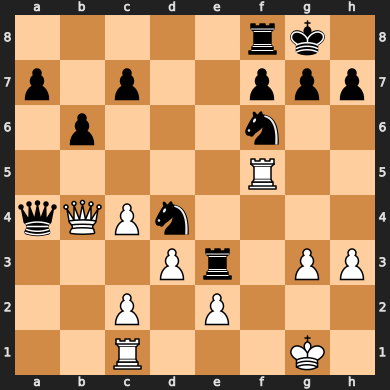

In [30]:
chess.Board('5rk1/p1p2ppp/1p3n2/5R2/qQPn4/3Pr1PP/2P1P3/2R3K1 b - - 2 20')
#find_best_move(chess.Board('2r2r1k/1pb1npp1/p2p2qp/4p3/4P3/1BP1R3/PP3PPP/R2Q2K1 w - - 0 20'))

In [45]:
board = chess.Board('4k3/3r4/8/8/PPPQ1PPP/3K4/8/8 w - - 0 1')
model.predict(np.array([get_training_data(board)]))
#s,_ = find_best_move(board)
#print(s)
#get_top_1(['5rk1/p1p2ppp/1p3n2/5R2/qQPn4/3Pr1PP/2P1P3/2R3K1 b - - 2 20'])

array([[0.5408865]], dtype=float32)

In [275]:
board = chess.Board('5rk1/p1p2ppp/1p3n2/5R2/qQPn4/3Pr1PP/2P1P3/2R3K1 b - - 2 20')
#print(model.predict(np.array([get_training_data(board)])))

#board.attackers(board.turn)
print(board.turn, board.turn * -1)
move = 'a2a4'
print(len(board.attackers(False, chess.parse_square(str(move)[2:4]))))
#chess.parse_square('e4')

False 0
0
